In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from codes.docs.analysis.nimagen import stats, visualisation, graph,genes
from codes.docs.analysis import data_preprocessing, genetic_file_preprocess

import glob
dataset_path = "../../dataset"
preprocessed_dataset_path = "./preprocessed_dataset"

In [2]:
from joblib import Parallel, delayed
import time
import tqdm
import glob
import os

In [3]:

european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')
european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

PRS_imputed_Grove = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_nodups_euro_batch2_imputed.gwas.all_score',column_prefix='ASD_imputed_PRS_')
european_volumetric_dataset_term = european_volumetric_dataset_term.merge(PRS_imputed_Grove,on='ID')

available_dwi = pd.read_csv('../../codes/FBA/subject_lists/available_dwi.txt',header=None,names=['ID','Session'])
available_dwi['ID/Ses'] = available_dwi['ID']+'/'+available_dwi['Session'].astype('str')

def concat_files(files):
    to_return = pd.DataFrame()
    for variable,file in files.items():
        temp = pd.read_csv(file,delim_whitespace=True,header=None)
        temp.columns = ['ID/Ses']+[f'wm_{i}_{variable}' for i in range(94,148)]
        temp = temp.drop_duplicates('ID/Ses')
        temp['ID/Ses'] = temp['ID/Ses'].apply(lambda x: x.replace('_','/'))
        temp = temp.set_index('ID/Ses')
        to_return = pd.concat([to_return,temp],axis=1)
    return to_return.reset_index()

tract_metrics = concat_files({'fd':'../../codes/FBA/output_ASD/aba/mean_fd_not_smoothed_linear.txt',
                     'log_fc':'../../codes/FBA/output_ASD/aba/mean_log_fc_not_smoothed_linear.txt',
                     'fdc':'../../codes/FBA/output_ASD/aba/mean_fdc_not_smoothed_linear.txt'})

df = european_volumetric_dataset_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)

df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

df = stats.MassUnivariate.remove_outliers(
    df,
    col=['WM','GM','TBV','ICV'],
    threshold=3.5,
    remove_schemes='any')

df = pd.merge(df,tract_metrics,on=['ID/Ses'],how='inner')

pheno = df[['ID','wm_102_log_fc']].copy()
ids = pd.read_csv('../../codes/FBA/output_ASD/tractography/fba/whole_brain/ASD_Grove_imputed/pos/ASD_imputed_Pt_001/stats_log_fc/id_file_imputed.txt',header=None,names=['ID/Ses'])
covar = pd.read_csv('../../codes/FBA/output_ASD/tractography/fba/whole_brain/ASD_Grove_imputed/pos/ASD_imputed_Pt_001/stats_log_fc/ASD_imputed_Pt_001_design.txt',delim_whitespace=True)

covar = pd.concat([ids,covar],axis=1)

covar['FID'] = covar['ID/Ses'].apply(lambda x: x.split('_')[0].replace('sub-',''))

covar = covar[['FID','sex_male','GA','PMA','TBV','ASD_imputed_Pt_001','AncPC1','AncPC2','AncPC3']].copy()

pheno = pheno.rename(columns={'ID':'FID'})

In [4]:
snp_file = pd.read_table('../../codes/gene_set/PRSice/output/asd/ASD_imputed.snp')
best_SNPs=genes.SNPsFunctionalAnalysis.get_the_best_SNPs(snp_file,threshold=0.01)

In [5]:
best_SNPs

,CHR,SNP,BP,P,Base
0,20,20:21248116,21248116,2.041000e-09,1
1,1,1:96511272,96511272,3.794000e-07,1
2,1,1:96978961,96978961,1.135000e-07,1
3,1,1:104792257,104792257,6.983000e-07,1
4,3,3:62481063,62481063,2.069000e-07,1
...,...,...,...,...,...
5610,22,22:48385693,48385693,6.472000e-03,1
5611,22,22:48500387,48500387,3.105000e-03,1
5612,22,22:48706516,48706516,5.277000e-03,1
5613,22,22:49594796,49594796,6.279000e-03,1


In [6]:
best_SNPs_annot = genes.SNPsFunctionalAnalysis(snps_list=best_SNPs.SNP.to_list(),
                                                      bed_file=f'{dataset_path}/genetic_dataset/target_files/batch2/euro_batch2_imputed.bed')

In [11]:
updated_bed_file,best_SNPs_annot.snp_association = best_SNPs_annot.do_mass_univariate_test(
    orig_bed_file=best_SNPs_annot.orig_bed_file,
    snps_list=best_SNPs_annot.snps_list,
    pheno_file=pheno,
    covar_file=covar,
    phenotype="wm_102_log_fc")

 ... (more hidden) ...


In [12]:
# best_SNPs_annot.snp_association.to_csv('wm_102_log_fc_Pt_001.txt',index=False,sep='\t')

In [7]:
best_SNPs_annot.snp_association = pd.read_csv('wm_102_log_fc_Pt_001.txt',sep='\t')

In [8]:
best_SNPs_annot.snps_list = best_SNPs_annot.get_the_best_SNPs(best_SNPs_annot.snp_association,
                                  pcolumn=f'P',
                                  threshold=0.05)
variable_threshold = '5em2'

In [9]:
combined_table = best_SNPs_annot.snps_list.merge(best_SNPs,on='SNP',how='inner',suffixes=['_WM','_base']).copy()

In [10]:
best_SNPs_annot.genes_ID, best_SNPs_annot.snp_ID = best_SNPs_annot.SNPs_annotation_to_gene(
    snps_list=best_SNPs_annot.snps_list.SNP.tolist(),
    gene_build_path=
    f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
    window_size=0)

In [11]:
combined_table = combined_table.merge(best_SNPs_annot.snp_ID,right_on='SNP_ID',left_on='SNP',how='inner')

In [85]:
# with open('../../dataset/preprocessed_dataset/asd/GSEA/SCR_genes.txt','a') as f:
#     for i in best_SNPs_annot.genes_ID.Gene_ID.to_list():
#         f.writelines(str(i)+'\n')
        

In [12]:
msigdb_dataset = '../../dataset/genetic_dataset/pathway_database/MSigDB/MSigDB_custom_entrez.gmt'
background_gene = '../../dataset/genetic_dataset/gene_build/NCBI37_gene_loc.txt'
gene_job = '../../dataset/preprocessed_dataset/asd/GSEA/SCR_genes.txt'

In [14]:
observed_pathways = genes.GeneSetEnrichment.ora(msigdb_dataset,background_gene,gene_job,multiple_comparison='fdr')

100%|████████████████████████████████| 13159/13159 [01:11<00:00, 183.61it/s]


In [17]:
# observed_pathways.to_csv('../../dataset/preprocessed_dataset/asd/GSEA/fba/observed_pathways.csv',index=False)

In [12]:
observed_pathways = pd.read_csv('../../dataset/preprocessed_dataset/asd/GSEA/fba/observed_pathways.csv')

In [20]:
mkdir -p ../../dataset/preprocessed_dataset/asd/GSEA/fba/random

In [13]:
best_SNPs = genes.SNPsFunctionalAnalysis.get_the_best_SNPs(snp_file,threshold=0.05)

In [14]:
snp_file = pd.read_table('../../codes/gene_set/PRSice/output/asd/ASD_imputed.snp')
best_SNPs=genes.SNPsFunctionalAnalysis.get_the_best_SNPs(snp_file,threshold=0.01)

def create_random_genesets(job):
    random_SNPs = best_SNPs.sample(307)
    random_SNPs_annot = genes.SNPsFunctionalAnalysis(
        snps_list=random_SNPs.SNP.to_list(),
        bed_file=
        '../../dataset/genetic_dataset/target_files/batch2/euro_batch2_imputed.bed'
    )
    random_SNPs_annot.genes_ID, random_SNPs_annot.snp_ID = random_SNPs_annot.SNPs_annotation_to_gene(
        snps_list=random_SNPs.SNP.tolist(),
        gene_build_path=
        f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
        window_size=0)
    random_SNPs_annot.genes_ID[['Gene_ID']].to_csv(
        f'../../dataset/preprocessed_dataset/asd/GSEA/fba/random/random_genes_all{job}.txt',
        header=False,
        index=False,
        sep=' ')

def generate_best_enriched_path(job):
    msigdb_dataset ='../../dataset/genetic_dataset/pathway_database/MSigDB/MSigDB_custom_entrez.gmt'
    background_gene = '../../dataset/genetic_dataset/gene_build/NCBI37_gene_loc.txt'
    gene_job = f'../../dataset/preprocessed_dataset/asd/GSEA/fba/random/random_genes_all{job}.txt'
    res = genes.GeneSetEnrichment.ora(msigdb_dataset,background_gene,gene_job,multiple_comparison='fdr',disable_tqdm=True)
    res['run'] = job
    res = res.sort_values(by='adjP')
    res = res[res['adjP']<0.05]
    output_file = '../../dataset/preprocessed_dataset/asd/GSEA/fba/random/random_enriched_paths.csv'
    if not os.path.isfile(output_file):
        res.head(3).to_csv(output_file, header='column_names')
    else: # else it exists so append without writing the header
        res.head(3).to_csv(output_file, mode='a', header=False)

In [25]:
import time
start=time.time()
tasks = [delayed(create_random_genesets)(i) for i in range(0,1000)]
Parallel(n_jobs=-1)(tqdm.tqdm(tasks))
end = time.time()
print((end-start))

100%|███████████████████████████████████| 1000/1000 [00:43<00:00, 22.78it/s]


46.3598837852478


In [27]:
start=time.time()
tasks = [delayed(generate_best_enriched_path)(i) for i in range(1000)]
Parallel(n_jobs=-1)(tqdm.tqdm(tasks))
end = time.time()
print((end-start))

100%|█████████████████████████████████| 1000/1000 [1:37:57<00:00,  5.88s/it]


6182.698996543884


In [15]:
random_run = pd.read_csv('../../dataset/preprocessed_dataset/asd/GSEA/fba/random/random_enriched_paths.csv')
random_run = random_run.groupby('run').head(1)
random_run = pd.DataFrame(random_run.GeneSet.value_counts())
# random_run = random_run[random_run['GeneSet']>50]

In [19]:
random_run[random_run['count']>50]

,count
GeneSet,
GOCC_SYNAPSE,72
GOBP_BIOLOGICAL_ADHESION,61


In [16]:
observed_pathways = observed_pathways[observed_pathways['adjP']<0.05].copy()

In [17]:
observed_pathways['genes_name'] = observed_pathways['genes'].apply(lambda x: ':'.join([best_SNPs_annot.genes_ID[best_SNPs_annot.genes_ID['Gene_ID']==int(i)].NAME.tolist()[0][0] for i in x.split(':')]))

In [18]:
observed_pathways = observed_pathways[observed_pathways['GeneSet']!='GOCC_SYNAPSE'].copy()

In [18]:
observed_pathways

,GeneSet,N_genes,N_overlap,p,genes,adjP,genes_name
11029,GOCC_NEURON_PROJECTION,1330,24,4.165501e-06,5909:3752:6546:6538:4134:5067:6092:214:2895:37...,0.018271,RAP1GAP:KCND3:SLC8A1:SLC6A11:MAP4:CNTN3:ROBO2:...
11062,GOCC_CELL_BODY,541,18,1.322342e-08,5909:3752:460:6546:72:5136:214:3781:135138:260...,0.000174,RAP1GAP:KCND3:ASTN1:SLC8A1:ACTG2:PDE1A:ALCAM:K...


In [19]:
test = combined_table[combined_table['N_Genes']==1].copy()
test['Genes_Name'] = test['Genes_Name'].apply(lambda x: x[0])

In [19]:
neuron_projection_list = observed_pathways.loc[observed_pathways['GeneSet']=='GOCC_NEURON_PROJECTION','genes_name'].tolist()[0].split(':')
cell_body_list = observed_pathways.loc[observed_pathways['GeneSet']=='GOCC_CELL_BODY','genes_name'].tolist()[0].split(':')

In [26]:
test['pathway'] = ['neuron_projection' if i in neuron_projection_list else 'cell_body' if i in cell_body_list else 'None' for i in test['Genes_Name']]

In [27]:
test[test['pathway']!='None'].sort_values(by='P_base').to_csv('pathway_snps.csv',sep='\t')

In [28]:
combined_table[combined_table['N_Genes']>1]

,SNP,A1,BETA,STAT,P_WM,CHR,BP,P_base,Base,SNP_ID,Genes_list,N_Genes,Genes_Name
4,1:55079648,G,-0.021003,-3.033236,0.002722,1,55079648,0.009568,1,1:55079648,"[26027, 338094]",2,"[ACOT11, FAM151A]"


In [20]:
observed_pathways['Proportion'] = (observed_pathways['N_overlap']/observed_pathways['N_genes'])

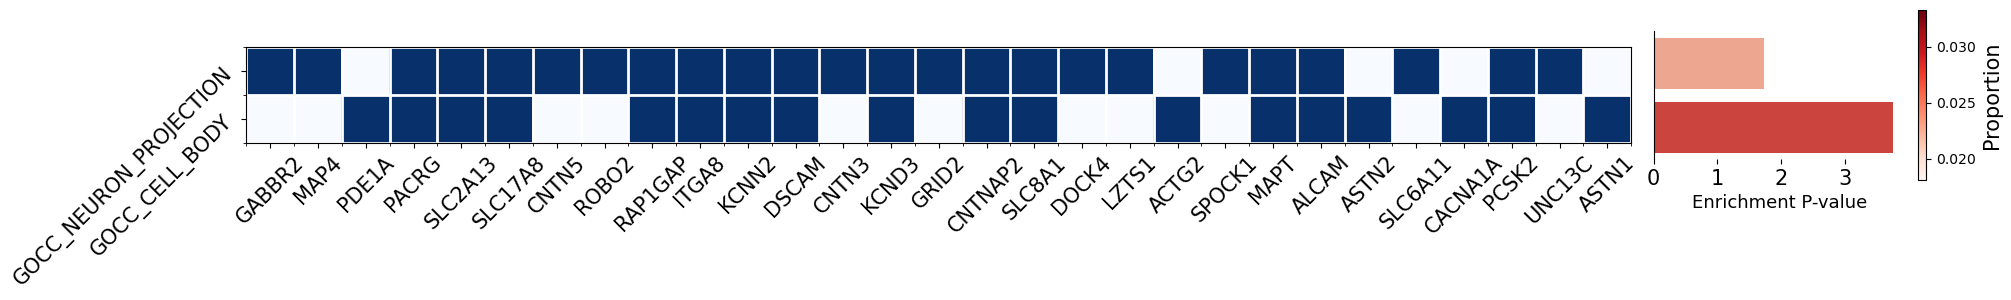

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(20,8),layout='constrained')
gs = fig.add_gridspec(4,8,width_ratios=[1,1,1,1,6,1,1,1])

# ax_barplot_top = fig.add_subplot(gs[0,0:6])
ax_heatmap = fig.add_subplot(gs[1,0:6])
ax_enrichment = fig.add_subplot(gs[1,6:8])

heatmap, all_genes,gene_sets = visualisation.Geneset.create_heatmap(observed_pathways,
                                                                   genes_set_column='GeneSet',
                                                                   genes_list_column='genes_name',
                                                                   top=50,
                                                                   )

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,all_genes=all_genes,gene_sets=gene_sets,ax=ax_heatmap)

# ax_heatmap.set_aspect(1.5)

visualisation.Geneset.visualise_enrichment_p_value(observed_pathways,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=ax_enrichment)
ax_enrichment.set_aspect(1)
ax_enrichment.tick_params('x',labelsize=15)
ax_enrichment.set_xlabel('Enrichment P-value',fontsize=13)
sns.despine(top=True,bottom=True,right=True,ax=ax_enrichment)
# plt.tight_layout()
fig.savefig('enrichment_pval.svg',transparent=True)


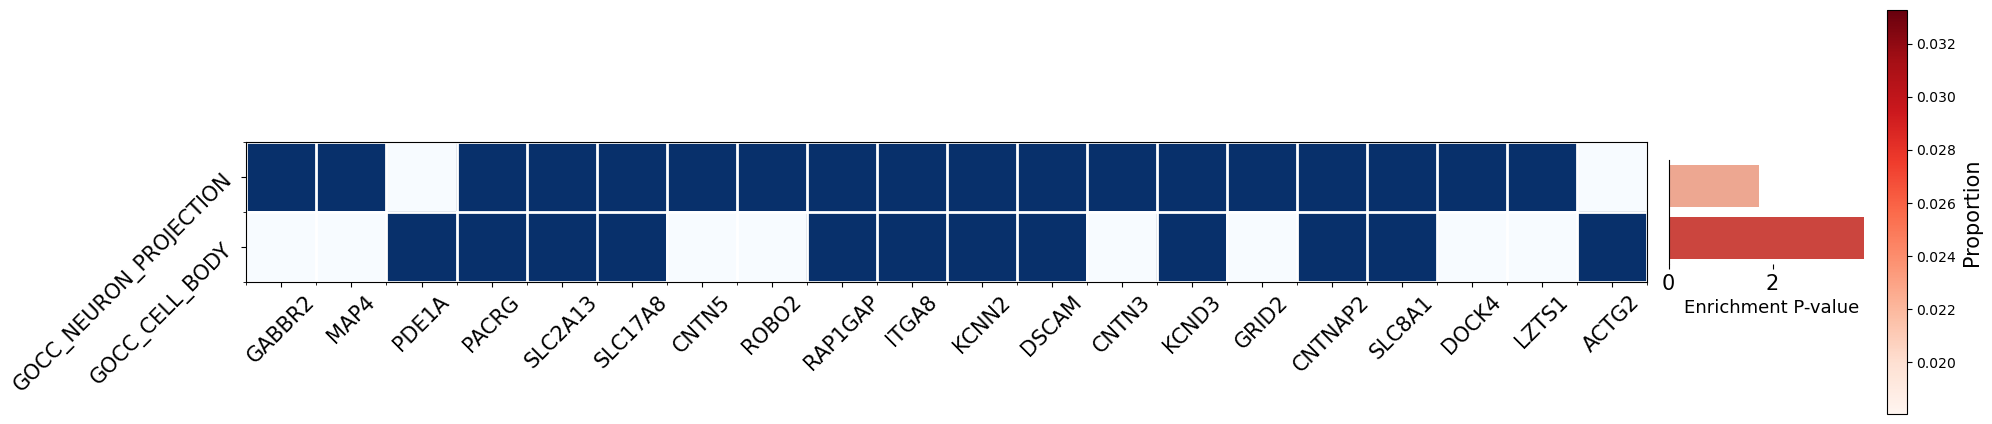

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(20,18))
gs = fig.add_gridspec(4,8,width_ratios=[1,1,1,1,6,1,1,1])

# ax_barplot_top = fig.add_subplot(gs[0,0:6])
ax_heatmap = fig.add_subplot(gs[1,0:6])
ax_enrichment = fig.add_subplot(gs[1,6:8])

heatmap, all_genes,gene_sets = visualisation.Geneset.create_heatmap(observed_pathways,
                                                                   genes_set_column='GeneSet',
                                                                   genes_list_column='genes_name',
                                                                   )

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,all_genes=all_genes,gene_sets=gene_sets,ax=ax_heatmap)

# ax_heatmap.set_aspect(1.5)

visualisation.Geneset.visualise_enrichment_p_value(gene_set_table=observed_pathways,
                                                  x='adjP',
                                                  y='GeneSet',
                                                  colour_by='Proportion',
                                                  ax=ax_enrichment)
ax_enrichment.set_aspect(1)
ax_enrichment.tick_params('x',labelsize=15)
ax_enrichment.set_xlabel('Enrichment P-value',fontsize=13)
sns.despine(top=True,bottom=True,right=True,ax=ax_enrichment)
plt.tight_layout()
fig.savefig('enrichment_pval.png',transparent=True)


In [ ]:

visualisation.Geneset.visualise_gene_p_value(gene_table=observed_pathways,
                                            all_genes=all_genes,
                                            gene_table_gene_name='genes_name',
                                            ordered_by='p',
#                                             coloured_by='P_ASD',
                                            p_threshold=None,
                                            bar_number='N_SNP',
                                             ax=ax_barplot_top,
                                            cbar_ax = cax,ylabel='FT',cbar_label='ASD')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

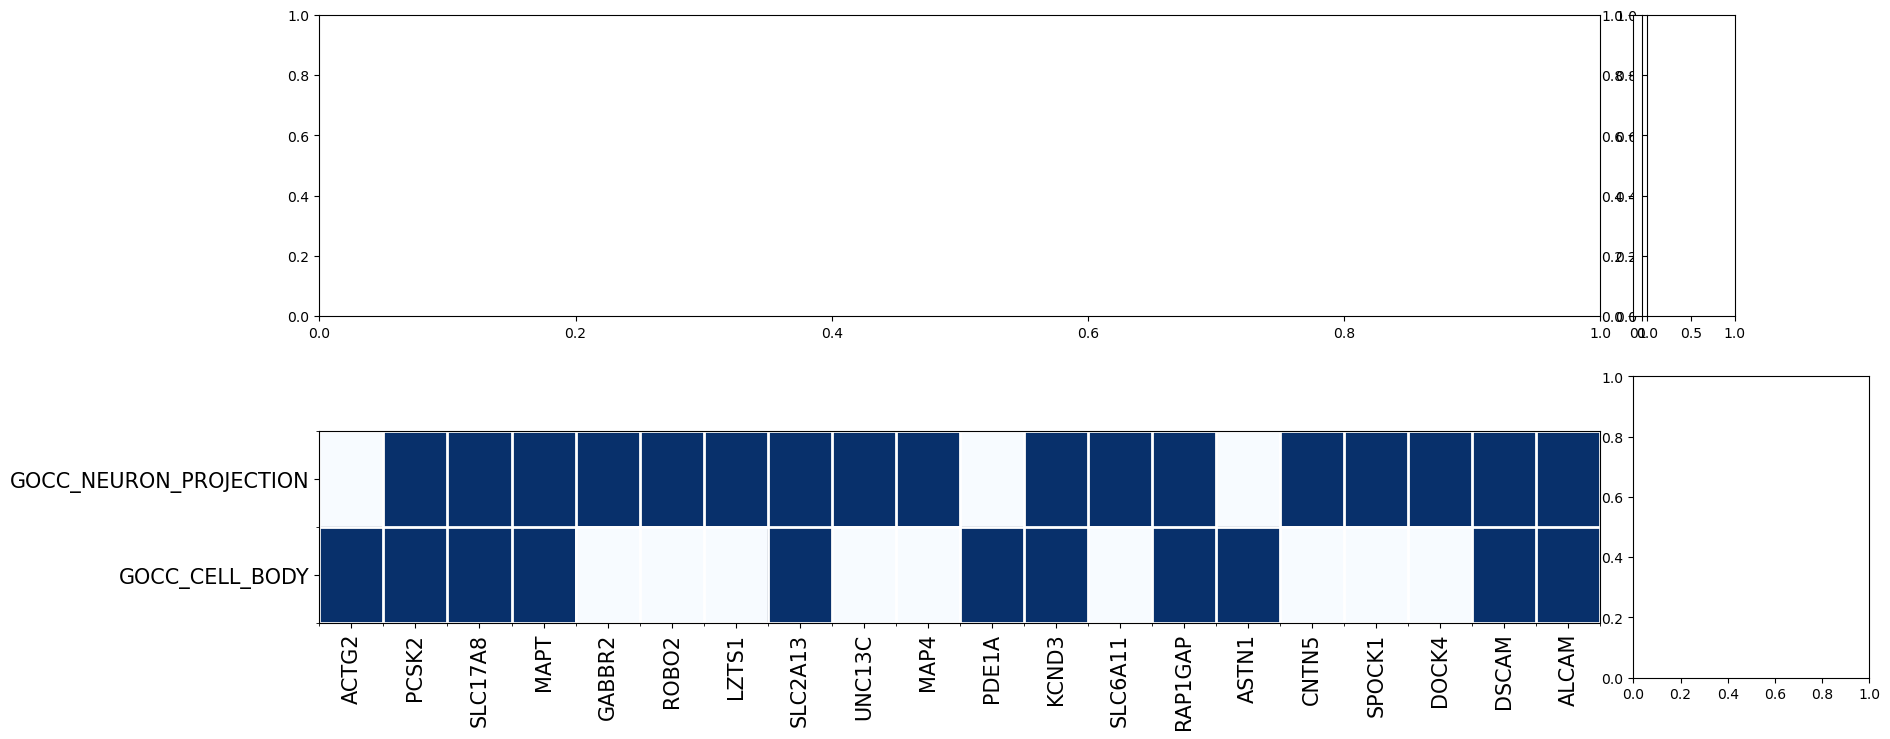

In [125]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(20,18))
gs = fig.add_gridspec(4,8,width_ratios=[1,1,1,1,6,1,1,1])

ax_barplot_top = fig.add_subplot(gs[0,0:6])
ax_heatmap = fig.add_subplot(gs[1,0:6])
ax_enrichment = fig.add_subplot(gs[1,6:8])

heatmap, all_genes,gene_sets = visualisation.Geneset.create_heatmap(observed_pathways,
                                                                   genes_set_column='GeneSet',
                                                                   genes_list_column='genes_names_id')

visualisation.Geneset.visualise_heatmap(heatmap=heatmap,
                                       all_genes=all_genes,
                                       gene_sets=gene_sets,
                                       ax=ax_heatmap)
ax_heatmap.set_aspect(1.5)
ax_heatmap.tick_params('y',rotation=0)
ax_heatmap.tick_params('x',rotation=90)

cbar_ax = fig.add_subplot(gs[0,6])
divider = make_axes_locatable(cbar_ax)
cax = divider.append_axes('left', size='10%', pad=0.05)


visualisation.Geneset.visualise_gene_p_value(gene_table=observed_pathways,
                                            all_genes=all_genes,
                                            gene_table_gene_name='genes_names_id',
                                            ordered_by='p',
#                                             coloured_by='P_ASD',
                                            p_threshold=None,
                                            bar_number='N_SNP',
                                             ax=ax_barplot_top,
                                            cbar_ax = cax,ylabel='FT',cbar_label='ASD')
ax_barplot_top.tick_params('y',labelsize=15)
sns.despine(top=True,left=True,right=True,ax=ax_barplot_top)
sns.despine(top=True,left=True,right=True,bottom=True,ax=cbar_ax)
cbar_ax.axis('off')

aspect = 1
ax_enrichment.set_aspect(aspect)
visualisation.Geneset.visualise_enrichment_p_value(FT_best_res,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=ax_enrichment)
ax_enrichment.tick_params('x',labelsize=15)
ax_enrichment.set_xlabel('Enrichment P-value',fontsize=15)
sns.despine(top=True,bottom=True,right=True,ax=ax_enrichment)
plt.tight_layout()

In [ ]:
! head -n 5 ../../dataset/genetic_dataset/p

In [21]:
best_SNPs[['SNP','CHR','BP']].to_csv('../../codes/gene_set/magma/ASD_001.snp',sep='\t',index=False,header=None)

In [25]:
available_gene_IDs = pd.read_csv('../../dataset/genetic_dataset/target_files/batch2/euro_batch2_genotyped.fam',header=None,delim_whitespace=True)

In [196]:
with open('../../codes/FBA/subject_lists/available_dwi_with_all_ASD_PRS_after_ancestry_outliers_with_PRScs.txt',
         'r') as f:
    header = f.readlines()[0].replace('#','').replace('\n','').split(' ')[1:]
df = pd.read_csv('../../codes/FBA/subject_lists/available_dwi_with_all_ASD_PRS_after_ancestry_outliers_with_PRScs.txt',
                            comment='#',header=None,names=header)
ancestry = [i for i in df.columns if 'Anc' in i]

In [197]:
df['ID'] = df['ID/Ses'].apply(lambda x: x.split('/')[0].replace('sub-',''))

In [66]:
available_gene_IDs.columns = ['ID']+available_gene_IDs.columns.tolist()[1:]

In [67]:
weird_names = [i for i in available_gene_IDs['ID'].tolist() if '-' in i]

In [68]:
df['IID'] = [i+'-1' if any(i in n for n in weird_names) else i for i in df['ID'].tolist()]

In [69]:
df['FID'] = df['IID']

In [73]:
df['sex_coded'] = [0 if i == 'female' else 1 for i in df['sex'].tolist()]

In [76]:
covar = df[['FID','IID','sex_coded','TBV','GA','PMA']+ancestry].copy()

In [107]:
pheno = pd.read_csv('../../codes/FBA/output_ASD/tractography/individual_tracts/cst_L_R/mean-log_fc-cst_L_R-significant.txt',header=None,names=['CST_log_FC_mean'])
pheno = pd.concat([df[['FID','IID']],pheno],axis=1)

In [108]:
with open('../../codes/gene_set/magma/available_FBA_subj.covar','w') as file:
    file.write(' '.join(["#"] + covar.columns.tolist()) + '\n')
    covar.to_csv(file,header=None,index=None,sep='\t')
    
with open('../../codes/gene_set/magma/available_FBA_subj.pheno','w') as file:
    file.write(' '.join(["#"] + pheno.columns.tolist()) + '\n')
    pheno.to_csv(file,header=None,index=None,sep='\t')

In [90]:
! wc -l ../../codes/gene_set/magma/available_FBA_subj.pheno

222 ../../codes/gene_set/magma/available_FBA_subj.pheno


In [127]:
test_gene_set = pd.read_csv('../../codes/gene_set/magma/test.gsa.out',skiprows=[0,1,2,3],delim_whitespace=True)

In [125]:
test_gene_contained = pd.read_csv('../../codes/gene_set/magma/test.gsa.self.out',skiprows=[0],delim_whitespace=True)

In [129]:
test_gene_set.sort_values(by='P')

,VARIABLE,TYPE,NGENES,BETA,BETA_STD,SE,P,FULL_NAME
608,REACTOME_OLFACTORY_SIGNALING...,SET,2,2.51970,0.092438,0.65558,0.000063,REACTOME_OLFACTORY_SIGNALING_PATHWAY
2209,GOBP_SENSORY_PERCEPTION_OF_S...1,SET,8,1.20210,0.088026,0.34614,0.000265,GOBP_SENSORY_PERCEPTION_OF_SMELL
3682,GOBP_INTERMEDIATE_FILAMENT_B...,SET,2,2.41990,0.088778,0.70415,0.000303,GOBP_INTERMEDIATE_FILAMENT_BASED_PROCESS
794,REACTOME_ACTIVATION_OF_SMO,SET,2,2.29510,0.084200,0.70427,0.000572,REACTOME_ACTIVATION_OF_SMO
5838,GOCC_MYOSIN_FILAMENT,SET,5,1.41850,0.082197,0.44602,0.000751,GOCC_MYOSIN_FILAMENT
...,...,...,...,...,...,...,...,...
3922,GOBP_EMBRYONIC_EYE_MORPHOGEN...,SET,3,-1.78290,-0.080081,0.57555,0.999010,GOBP_EMBRYONIC_EYE_MORPHOGENESIS
6782,GOMF_BMP_RECEPTOR_BINDING,SET,2,-1.87900,-0.068933,0.58657,0.999310,GOMF_BMP_RECEPTOR_BINDING
6281,GOMF_GROWTH_FACTOR_ACTIVITY,SET,12,-0.90069,-0.080665,0.27657,0.999420,GOMF_GROWTH_FACTOR_ACTIVITY
1478,WP_EMBRYONIC_STEM_CELL_PLURI...,SET,10,-1.06140,-0.086837,0.30928,0.999690,WP_EMBRYONIC_STEM_CELL_PLURIPOTENCY_PATHWAYS


In [135]:
genes_pval = pd.read_csv('../../codes/gene_set/magma/test.genes.out',delim_whitespace=True)

In [137]:
genes_pval.sort_values(by='P')

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,RSQ,RSQ_ADJ
1215,10598,14,77922873,77937315,1,1,221,3.5245,0.000212,6.086300e-02,0.056575
322,10217,3,37902169,38027460,1,1,221,3.3884,0.000351,5.678500e-02,0.052478
176,109,2,25040538,25144102,1,1,221,3.3097,0.000467,5.449100e-02,0.050174
138,55740,1,225673034,225842345,1,1,221,3.0782,0.001041,4.802000e-02,0.043673
541,4012,5,96269846,96366615,1,1,221,2.7678,0.002822,3.999800e-02,0.035615
...,...,...,...,...,...,...,...,...,...,...,...
493,729830,4,152328898,152593155,1,1,221,-2.7823,0.997300,5.236500e-08,0.000000
469,5910,4,99181027,99366512,1,1,221,-2.8280,0.997660,3.943700e-08,0.000000
278,1419,2,209005797,209012377,1,1,221,-2.9446,0.998380,1.878800e-08,0.000000
1016,22941,11,70312461,70937308,2,2,221,-3.0466,0.998840,1.062100e-05,0.000000


In [150]:
genes_pval[genes_pval['P']<0.05][['GENE']].to_csv('../../codes/gene_set/magma/significant_genes.txt',header=None,index=False)

In [157]:
all_genes = pd.read_table('../../codes/gene_set/PRSice/genetic_dataset/gene_build/EnsembleGRCh37.87.gene_without_havana.loc',header=None)

In [158]:
all_genes

,0,1,2,3,4,5
0,ENSG00000223972,1,11869,14412,+,DDX11L1
1,ENSG00000227232,1,14363,29806,-,WASH7P
2,ENSG00000243485,1,29554,31109,+,MIR1302-10
3,ENSG00000237613,1,34554,36081,-,FAM138A
4,ENSG00000268020,1,52473,54936,+,OR4G4P
...,...,...,...,...,...,...
30750,ENSG00000271726,GL000247.1,12803,12884,-,CU442762.4
30751,ENSG00000215616,GL000201.1,3905,22432,+,AC002321.2
30752,ENSG00000215611,GL000201.1,26348,27637,-,AC002321.1
30753,ENSG00000265557,GL000231.1,21878,21950,-,CT867977.1


In [160]:
pd.read_table('../../codes/gene_set/PRSice/genetic_dataset/gene_build/NCBI37.3.gene.loc',header=None)

,0,1,2,3,4,5
0,79501,1,69091,70008,+,OR4F5
1,100996442,1,142447,174392,-,LOC100996442
2,729759,1,367659,368597,+,OR4F29
3,81399,1,621096,622034,-,OR4F16
4,148398,1,859993,879961,+,SAMD11
...,...,...,...,...,...,...
19422,442867,Y,26764151,26785354,+,BPY2B
19423,57054,Y,26909216,26959639,-,DAZ3
19424,57135,Y,26979967,27053187,+,DAZ4
19425,442868,Y,27177048,27198251,-,BPY2C


In [168]:
with open('../../codes/gene_set/PRSice/GOCC_POSTSYNAPTIC_MEMBRANE.v2023.1.Hs.gmt','r') as f:
    test = f.readlines()[0].split('\t')
# pd.read_table('../../codes/gene_set/PRSice/GOCC_POSTSYNAPTIC_MEMBRANE.v2023.1.Hs.gmt')

In [174]:
with open('../../codes/gene_set/PRSice/postsynaptic_membrane.txt','r') as f:
    test2 = f.readlines()
# pd.read_table('../../codes/gene_set/PRSice/GOCC_POSTSYNAPTIC_MEMBRANE.v2023.1.Hs.gmt')

In [175]:
test2 = [i.replace('\n','') for i in test2]

In [178]:
len(test)

279

In [189]:
with open('../../codes/gene_set/PRSice/all_pathways.gmt','w') as f2:
    for path in ['postsynaptic_membrane','postsynaptic_density','dendritic_spine','axon','histone']:
        with open(f'../../codes/gene_set/PRSice/{path}.txt','r') as f:
            test2 = f.readlines()
            test2 = [i.replace('\n','') for i in test2]
            f2.writelines('\t'.join([path,'http://amigo.geneontology.org']+ test2))
            f2.writelines('\n')
       

In [192]:
test = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRSice/test.all_score')

<AxesSubplot:xlabel='standardize(postsynaptic_membrane_0.01)', ylabel='standardize(dendritic_spine_0.01)'>

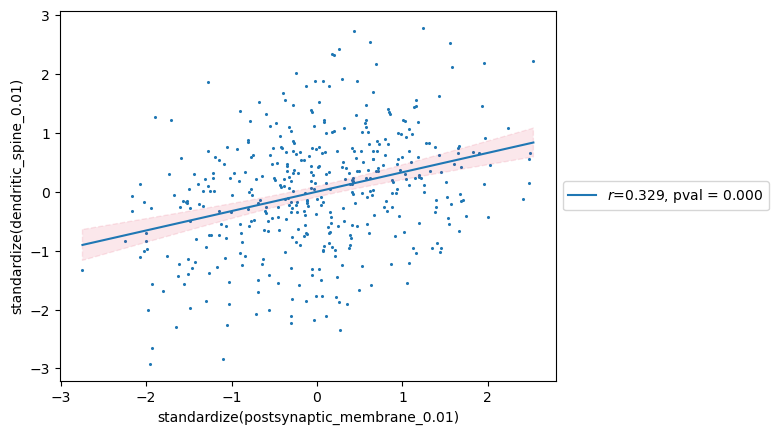

In [195]:
visualisation.SimplePlots.Scatter(data=test,
                                 x='postsynaptic_membrane_0.01',y='dendritic_spine_0.01')

In [199]:
df['ID'] = df['ID/Ses'].apply(lambda x: x.split('/')[0].replace('sub-',''))

In [204]:
to_copy = df.merge(test,on='ID')

In [209]:
to_copy = to_copy[['ID/Ses','sex','GA','PMA','TBV']+[i for i in test.columns if '_0.01' in i and 'Base_' not in i]+ancestry]

In [211]:
with open('../../codes/FBA/subject_lists/available_dwi_with_pathwayPRS_after_outlier.txt','w') as file:
    file.write(' '.join(["#"] + to_copy.columns.tolist()) + '\n')
    to_copy.to_csv(file,header=None,index=None)
    

In [212]:
df= to_copy.copy()

In [221]:
mean_fd = pd.read_csv('../../codes/FBA/output_APOE/aba/mean_fd.txt',header=None,delim_whitespace=True)
mean_fd.columns = ['ID/Ses']+[f'wm_{i}' for i in range(94,148)]

In [224]:
mean_fd['ID/Ses'] = mean_fd['ID/Ses'].apply(lambda x: x.replace('_','/'))

In [226]:
df = pd.merge(df,mean_fd,on='ID/Ses')

In [230]:
mass_uni = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df,
                                                                          thresholds=[i for i in df.columns if '_0.01' in i],
                                    cat_independentVar_cols=['sex'],
                                    cont_independentVar_cols=['GA','PMA']+ancestry,
                                                                         dependentVar_cols=[i for i in df.columns if 'wm_' in i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


In [234]:
mass_uni.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
146,wm_132,0.254589,6.130522e-283,-0.002336,0.050598,0.002240,0.003204,-0.000736,3.315960e-01,0.000914,0.126733,0.000046,0.939834,0.000617,0.307819,-1.670430e-03,0.005612,dendritic_spine_0.01
258,wm_136,0.256642,2.048308e-303,-0.001704,0.076504,0.001118,0.068278,0.001171,5.743379e-02,0.000759,0.117243,-0.000071,0.883550,0.000809,0.098889,-1.043125e-03,0.030810,histone_0.01
154,wm_140,0.204200,2.160195e-261,-0.004620,0.000164,0.000567,0.457065,0.008737,8.229963e-24,0.000684,0.258994,-0.000490,0.422288,-0.000122,0.841695,1.314057e-03,0.030915,dendritic_spine_0.01
153,wm_139,0.203897,2.678147e-258,-0.004409,0.000479,0.000929,0.238556,0.008690,1.611567e-22,0.000298,0.632984,-0.000527,0.403594,0.000181,0.775399,1.356395e-03,0.030977,dendritic_spine_0.01
99,wm_139,0.204028,1.490438e-258,-0.004669,0.000206,0.000841,0.286157,0.008744,1.274708e-22,0.000385,0.537180,-0.000511,0.418600,0.000274,0.664389,1.264102e-03,0.042252,postsynaptic_density_0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,wm_94,0.247785,4.921695e-257,-0.006089,0.000092,0.000601,0.537562,0.008807,1.264166e-16,-0.000503,0.514642,-0.000253,0.745607,0.000767,0.326247,-8.972741e-06,0.990663,histone_0.01
235,wm_113,0.212610,1.463324e-252,-0.002592,0.060936,0.000122,0.889602,0.004666,2.963930e-07,-0.000490,0.481118,-0.000597,0.395262,-0.000452,0.520303,5.750740e-06,0.993356,histone_0.01
157,wm_143,0.194629,4.185859e-210,-0.006539,0.001292,-0.001451,0.253674,0.012248,2.383507e-18,-0.001141,0.258364,-0.001430,0.160679,0.000232,0.820249,-8.193137e-06,0.993518,dendritic_spine_0.01
150,wm_136,0.256583,3.935201e-302,-0.001586,0.104423,0.001234,0.046176,0.001099,7.731767e-02,0.000810,0.098756,-0.000064,0.897297,0.000755,0.128349,7.820733e-07,0.998725,dendritic_spine_0.01
